<h1 align = 'center'>Análisis Económico del IPC y Tipo de Cambio en América Latina

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

Obteniendo datos del BM con su API

In [23]:
# Definiendo una funcion para obtener informacion económica pasando argumentos claves del API

def obtener_datos_banco_mundial(indicador, paises, fecha_desde, fecha_hasta):
    url = f"http://api.worldbank.org/v2/country/{paises}/indicator/{indicador}?date={fecha_desde}:{fecha_hasta}&format=json&per_page=1000"
    response = requests.get(url)
    data = response.json()[1]
    df = pd.DataFrame(data)
    df = df[['country', 'date', 'value']]
    df['country'] = df['country'].apply(lambda x: x['value'])
    df = df.rename(columns={'country': 'País', 'date': 'Año', 'value': 'Valor'})
    return df


Obteniendo indicadores  de Argentina, Brasil y Chile

In [24]:
paises = 'MX;BR;CL'  # Argentina, Brasil, Chile segun API
ipc = obtener_datos_banco_mundial('FP.CPI.TOTL.ZG', paises, 2010, 2023) 
tipo_cambio = obtener_datos_banco_mundial('PA.NUS.FCRF', paises, 2010, 2023)

Limpieza y transformación de datos

In [25]:
# Convesion del formato del año
ipc['Año'] = ipc['Año'].astype(int)
tipo_cambio['Año'] = tipo_cambio['Año'].astype(int)

# Cambiando indices y columnas para que la tabla sea mas entendible
ipc_pivot = ipc.pivot(index='Año', columns='País', values='Valor')
tipo_cambio_pivot = tipo_cambio.pivot(index='Año', columns='País', values='Valor')


In [26]:
print("Inflación (% anual):")
print(ipc_pivot.head(), "\n")

print("Tipo de Cambio (moneda local/USD):")
print(tipo_cambio_pivot.head(), "\n")

Inflación (% anual):
País    Brazil     Chile    Mexico
Año                               
2010  5.038727  1.410711  4.156727
2011  6.636450  3.341217  3.407378
2012  5.403499  3.007448  4.111510
2013  6.204311  1.789556  3.806391
2014  6.329040  4.718675  4.018616 

Tipo de Cambio (moneda local/USD):
País    Brazil       Chile     Mexico
Año                                  
2010  1.759227  510.249167  12.636008
2011  1.672829  483.667500  12.423325
2012  1.953069  486.471303  13.169458
2013  2.156089  495.272878  12.771992
2014  2.352952  570.348216  13.292450 



Análisis descriptivo del IPC por país

In [27]:
ipc_pivot.describe()


País,Brazil,Chile,Mexico
count,14.000000,14.000000,14.000000
mean,5.972312,4.026667,4.437859
std,2.173791,2.688432,1.430676
min,3.211768,1.410711,2.720641
25%,3.948123,2.465554,3.464524
50%,5.803905,3.193354,4.065063
75%,7.885357,4.480620,5.370808
max,9.280106,11.643867,7.896276


Análisis descriptivo del  Tipo de Cambio por país

In [28]:
tipo_cambio_pivot.describe()

País,Brazil,Chile,Mexico
count,14.000000,14.000000,14.000000
mean,3.443571,652.511587,16.848867
std,1.344960,131.848155,3.341109
min,1.672829,483.667500,12.423325
25%,2.205305,525.273929,13.200206
50%,3.409109,651.478938,18.211388
75%,4.731903,744.940890,19.258810
max,5.394401,873.314190,21.485608


Gráfico de la evolución de la inflación anual

<Figure size 1200x600 with 0 Axes>

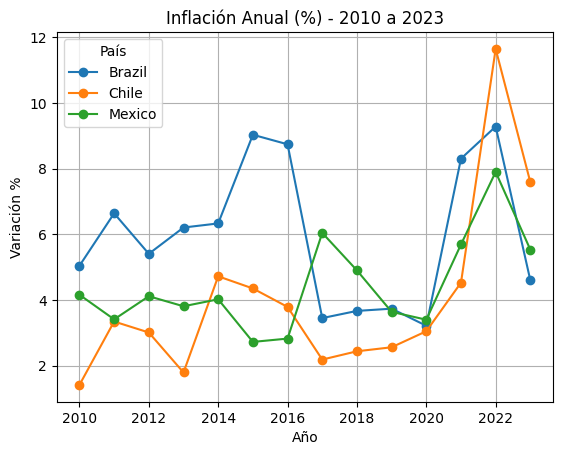

In [29]:
plt.figure(figsize=(12, 6))

ipc_pivot.plot(marker='o')

plt.title("Inflación Anual (%) - 2010 a 2023")
plt.ylabel("Variación %")
plt.xlabel("Año")
plt.grid(True)
plt.legend(title="País");

Gráfico de evolución del tipo de cambio

<Figure size 1200x600 with 0 Axes>

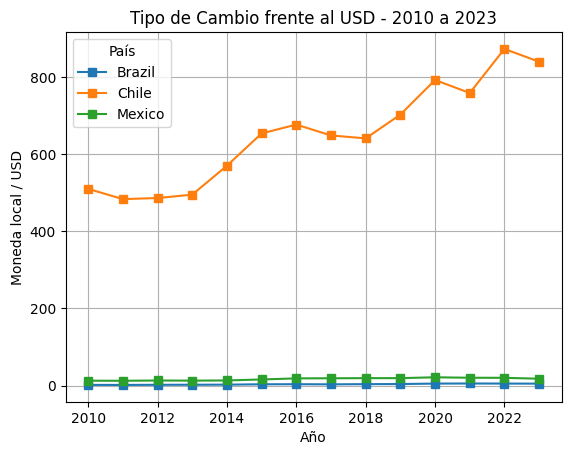

In [30]:
plt.figure(figsize=(12, 6))
tipo_cambio_pivot.plot(marker='s')
plt.title("Tipo de Cambio frente al USD - 2010 a 2023")
plt.ylabel("Moneda local / USD")
plt.xlabel("Año")
plt.grid(True)
plt.legend(title="País");


Análisis de correlación: Inflación vs Tipo de cambio

In [31]:
# Creando una lista vacia para luego acumular correlaciones en forma de diccionarios
correlaciones = []

# Creando bucle for, creando un dataframe por cada pais, que aparece como columna en ipc_pivot.

for pais in ipc_pivot.columns:
    
    # Cada Dataframe va a tener 2 columnas:  Inflación y Tipo de Cambio
    df_temp = pd.DataFrame({
        'Inflación': ipc_pivot[pais],
        'Tipo de Cambio': tipo_cambio_pivot[pais]
    }).dropna()
    
    # Se va a guardar la correlacion entre inflacion y tipo de cambio que se va a encontrar en la posicion [0,1]
    # de la matriz de correlación resultante de aplicar el metodo corr() a df_temp
    correlacion = df_temp.corr().iloc[0, 1]
    
    # Se va a crear un diccionario que gurade cada país y la correlación 
    correlaciones.append({'País': pais, 'Correlación': correlacion})

# Creando un DataFrame a partir de los diccionarios que creó el bucle for
df_corr = pd.DataFrame(correlaciones)

print("\nCorrelación entre Inflación y Tipo de Cambio:")
print(df_corr)


Correlación entre Inflación y Tipo de Cambio:
     País  Correlación
0  Brazil     0.071928
1   Chile     0.686058
2  Mexico     0.387568


Con estos datos se pueden obtener estas conclusiones:

<li>Brasil tiene una relación baja, demostrando independencia relativa entre estas dos variables en el período analizado.

<li>Chile tiene una correlación más alta, donde los movimientos del real frente al dólar tienden a impactar precios.


<li>México muestra una correlación moderada entre inflación y tipo de cambio, posiblemente por el control monetario y estabilidad macroeconómica.

Gráficos de dispersión y linea de tendencia para la relacion entre tIpo de Cambio e Inflacion por país

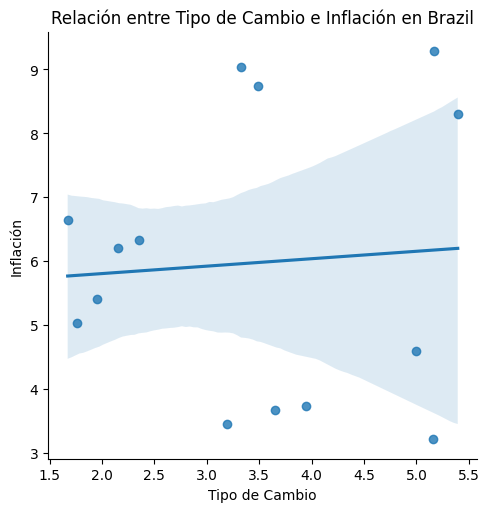

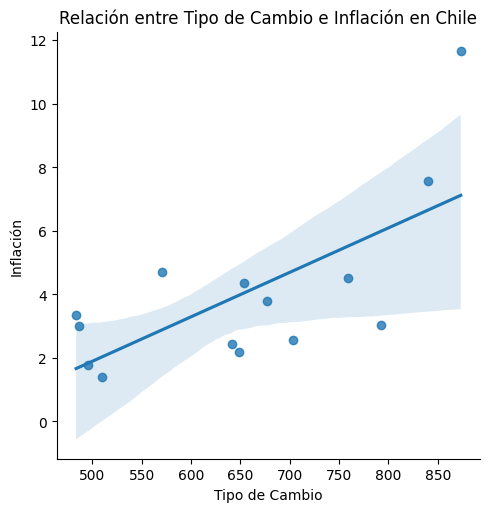

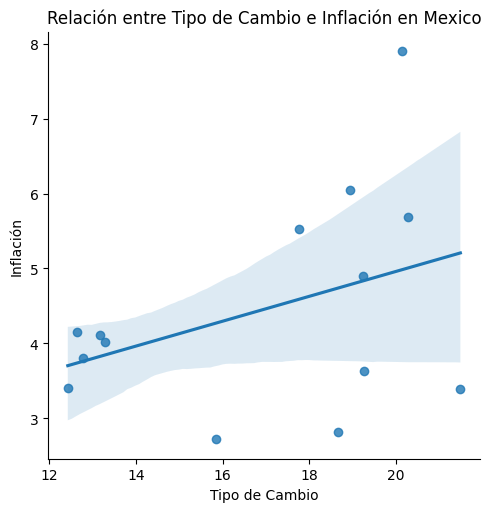

In [32]:
# Creando un gráfico de dispersión con línea de regresión lineal
for pais in ipc_pivot.columns:
    # Crea un Dataframe por cada país compuesta por su inflación y tipo de cambio
    df_temp = pd.DataFrame({
        'Inflación': ipc_pivot[pais],
        'Tipo de Cambio': tipo_cambio_pivot[pais]
    }).dropna()

    # A partir de cada dataframe creado genera un gráfico de dispersion + regresion lineal ajustada
    sns.lmplot(data=df_temp, x='Tipo de Cambio', y='Inflación')
    plt.title(f'Relación entre Tipo de Cambio e Inflación en {pais}');

Modelo predictivo de regresión lineal simple

Brazil

Inflación = 0.12 × TipoCambio + 5.57
R²: 0.005 | RMSE: 2.09


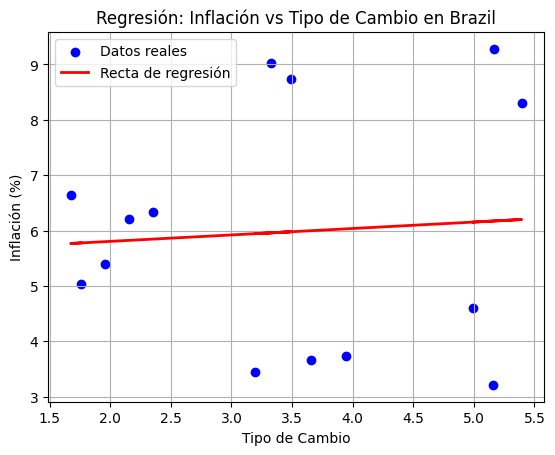

Chile

Inflación = 0.01 × TipoCambio + -5.10
R²: 0.471 | RMSE: 1.88


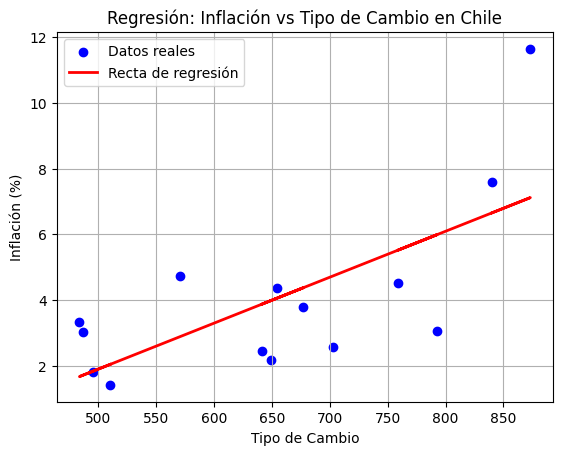

Mexico

Inflación = 0.17 × TipoCambio + 1.64
R²: 0.150 | RMSE: 1.27


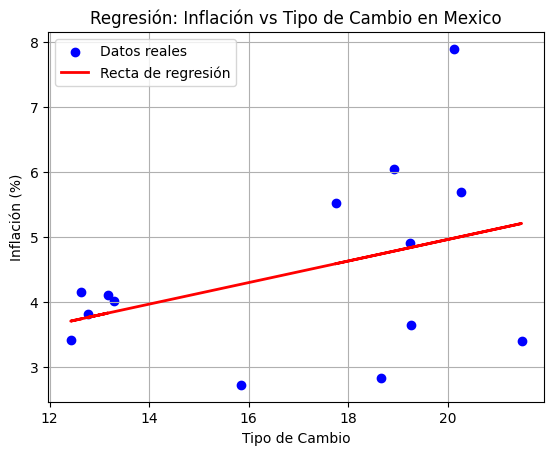

In [33]:
from sklearn.metrics import root_mean_squared_error


for pais in ipc_pivot.columns:
    
    # Crea un DataFrame por  pais con Inflación y Tipo de cambio
    df_temp = pd.DataFrame({
        'Inflación': ipc_pivot[pais],
        'Tipo de Cambio': tipo_cambio_pivot[pais]
    }).dropna()

    # Define la variable Independiente 'X' y la dependiente 'y'
    X = df_temp[['Tipo de Cambio']]   
    y = df_temp['Inflación']          

    # Define el modelo
    modelo = LinearRegression()
    
    # Entrena el modelo usando las variables dependiente e independiente definidas
    modelo.fit(X, y)

    # Predice el valor de la variable dependiete
    y_pred = modelo.predict(X)

    # Obtiene las métricas importantes
    coef = modelo.coef_[0]
    intercept = modelo.intercept_
    r2 = r2_score(y, y_pred)
    rmse = root_mean_squared_error(y, y_pred)

    # Exhibe la informacion
    print(f"{pais}\n")
    print(f"Inflación = {coef:.2f} × TipoCambio + {intercept:.2f}")
    print(f"R²: {r2:.3f} | RMSE: {rmse:.2f}")

    # Genera el gráfico correspondiente
    plt.scatter(X, y, color='blue', label='Datos reales')
    plt.plot(X, y_pred, color='red', linewidth=2, label='Recta de regresión')
    plt.title(f"Regresión: Inflación vs Tipo de Cambio en {pais}")
    plt.xlabel("Tipo de Cambio")
    plt.ylabel("Inflación (%)")
    plt.grid(True)
    plt.legend()
    plt.show()

Aplicando regresión lineal podemos ver que en el caso de:

<li>Brasil: El 00.5% de la variabilidad de la Inflación se puede explicar por el tipo de cambio

<li>Chile: El 47.1% de  la variabilidad de la inflación se puede explicar por el tipo de cambio

<li>México: El 15% de la variabilidad de la Inflación se puede explicar por le tipo de cambio

Si bien la correlacion entre la Inflacion y el Tipo de cambio en el caso de Chile fué de 0.686058, la capacidad de predecir la variación de la la inflación a partir del tipo de cambio es menor al 50%.
En el resto de los casos 